# Build the LSTM model using the VN30 dataset

VN30 is a stock market index in Vietnam. It represents the performance of the 30 largest and most liquid stocks listed on the Ho Chi Minh Stock Exchange (HOSE), which is the main stock exchange in Vietnam. The VN30 index is a widely followed benchmark for the Vietnamese stock market and provides investors with an overview of the performance of the top companies in the country. The composition of the VN30 index is periodically reviewed and adjusted to ensure that it accurately reflects the market conditions.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [2]:
import os
import pandas as pd
import numpy as np

# Define the sector of interest
vn30 = np.array(['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 
        'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE'])


In [3]:
# Load the historical price data for the selected tickers
paths = []  # List to store individual DataFrames
ticker_overview = pd.read_csv('ticker-overview.csv')

for stock in vn30:
    exchange = ticker_overview.loc[ticker_overview['ticker'] == stock, 'exchange'].iloc[0]
    
    if exchange == 'HOSE':
        path = os.path.join('stock-historical-data', stock + '-VNINDEX-History.csv')
        paths.append(path)
            
    elif exchange == 'HNX':
        path = os.path.join('stock-historical-data', stock + '-' + exchange + 'Index' + '-History.csv')
        paths.append(path)
            
    elif exchange == 'UPCOM':
        continue

In [4]:
paths

['stock-historical-data/ACB-VNINDEX-History.csv',
 'stock-historical-data/BCM-VNINDEX-History.csv',
 'stock-historical-data/BID-VNINDEX-History.csv',
 'stock-historical-data/BVH-VNINDEX-History.csv',
 'stock-historical-data/CTG-VNINDEX-History.csv',
 'stock-historical-data/FPT-VNINDEX-History.csv',
 'stock-historical-data/GAS-VNINDEX-History.csv',
 'stock-historical-data/GVR-VNINDEX-History.csv',
 'stock-historical-data/HDB-VNINDEX-History.csv',
 'stock-historical-data/HPG-VNINDEX-History.csv',
 'stock-historical-data/MBB-VNINDEX-History.csv',
 'stock-historical-data/MSN-VNINDEX-History.csv',
 'stock-historical-data/MWG-VNINDEX-History.csv',
 'stock-historical-data/NVL-VNINDEX-History.csv',
 'stock-historical-data/PDR-VNINDEX-History.csv',
 'stock-historical-data/PLX-VNINDEX-History.csv',
 'stock-historical-data/POW-VNINDEX-History.csv',
 'stock-historical-data/SAB-VNINDEX-History.csv',
 'stock-historical-data/SSI-VNINDEX-History.csv',
 'stock-historical-data/STB-VNINDEX-History.csv',


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
window_size = 30
X_data, y_data = [], []
for path in paths:
    df = pd.read_csv(path)
    df1 = df.reset_index()['Close']
    df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
    for i in range(len(df1)-window_size-7):
        a = df1[i:(i + window_size)]
        X_data.append(a)
        b = df1[(i + window_size):(i + window_size+7)] 
        y_data.append(b) 

In [6]:
### Split the data into training, validation and test set
from helper_functions import data_preprocessing as pp
X_train, y_train, X_val, y_val, X_test, y_test = pp.split_dataset(X_data, y_data, 0.1)

print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (58814, 30, 1)
Shape of validation set:  (6535, 30, 1)
Shape of test set:  (7261, 30, 1)


In [7]:
### Create and train the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(30, 1), activation='relu'))  # LSTM layer with 128 units
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(LSTM(50, activation='relu'))  
model.add(Dense(7))  # Dense output layer with 7 units

early_stopping = EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)
model.summary()


2023-05-23 23:57:50.141455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 7)                 357       
                                                                 
Total params: 51,157
Trainable params: 51,157
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [9]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=1028,verbose=1,callbacks = [early_stopping])

Epoch 1/20
58/58 [==============================] - 44s 666ms/step - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 2/20
58/58 [==============================] - 36s 621ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/20
58/58 [==============================] - 37s 629ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 4/20
58/58 [==============================] - 69s 1s/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/20
58/58 [==============================] - 41s 700ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/20
58/58 [==============================] - 37s 628ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 7/20
58/58 [==============================] - 35s 600ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 8/20
58/58 [==============================] - 35s 610ms/step - los

In [12]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred = model.predict(X_test)
y_pred_reshaped = np.reshape(y_pred, (-1, 1))
y_test_reshaped = np.reshape(y_test, (-1, 1))
print("MSE on the test set: ", mean_squared_error(y_pred_reshaped, y_test_reshaped))

227/227 [==============================] - 3s 12ms/step
MSE on the test set:  0.0008445169166780041


In [13]:
y_test[0]

array([[0.43579519],
       [0.44062868],
       [0.42935054],
       [0.43337845],
       [0.42935054],
       [0.42935054],
       [0.42451705]])

In [14]:
y_pred[0]

array([0.4562524 , 0.4547724 , 0.45813584, 0.45806992, 0.46014157,
       0.45524797, 0.45873073], dtype=float32)

# Use the LSTM model to predict on one sample: ACB

In [15]:
df_ACB = pd.read_csv(paths[0])

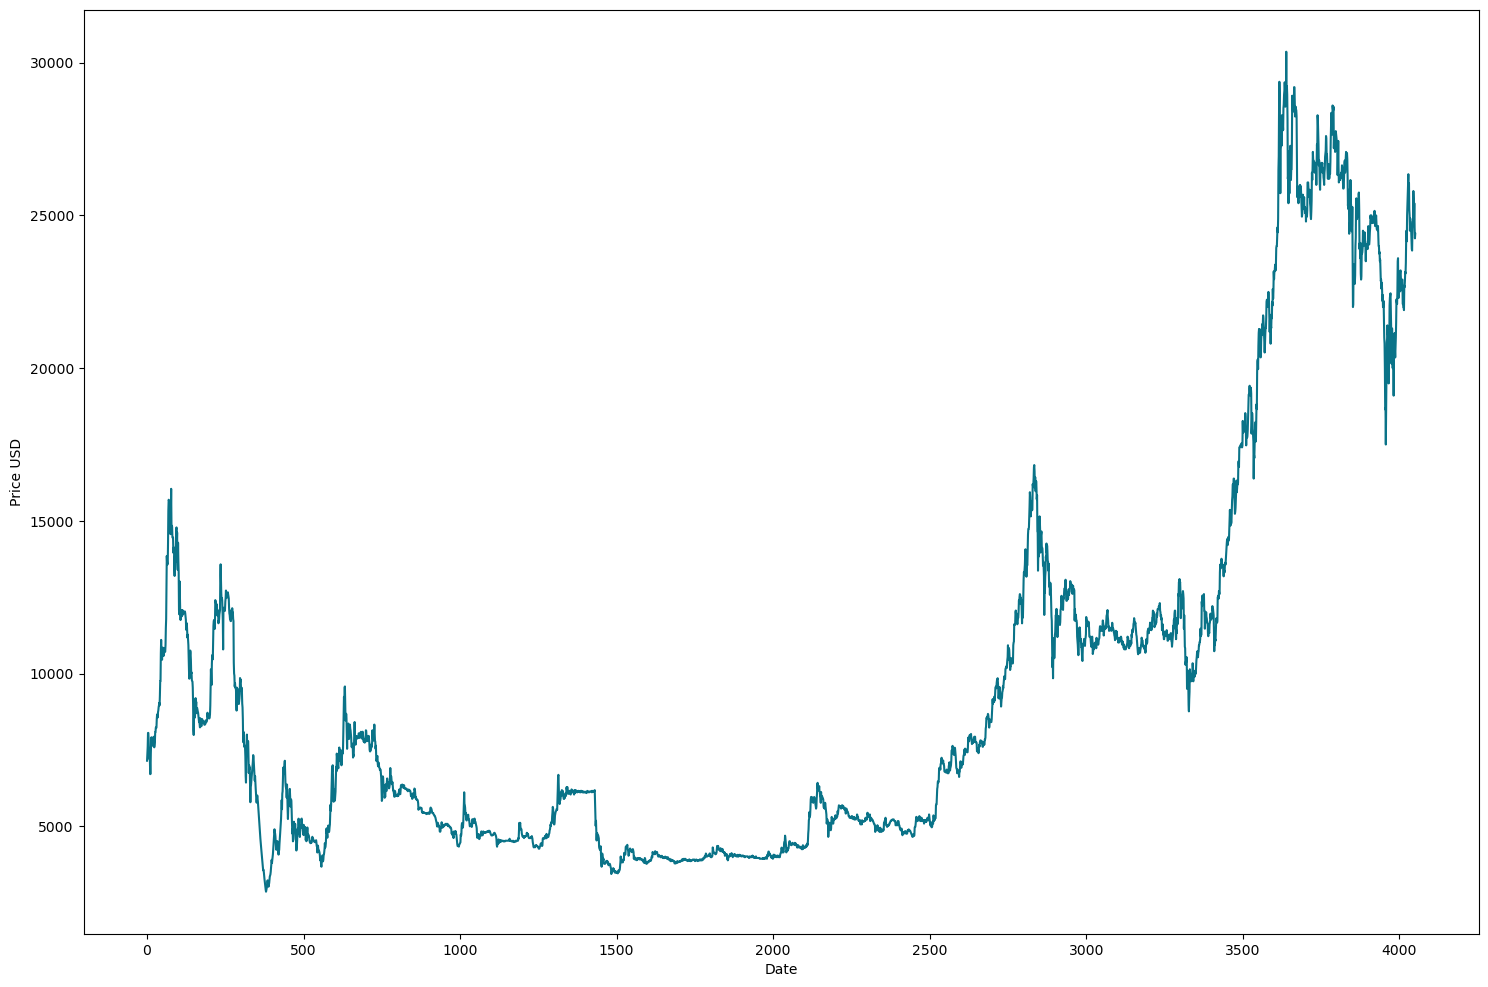

In [16]:
plt.rcParams['figure.figsize'] = (18, 12)

def price(x):
    """
    format the coords message box
    :param x: data to be formatted
    :return: formatted data
    """
    return '$%1.2f' % x

fig, ax = plt.subplots()
ax.plot(df_ACB.index, df_ACB['Close'], '#0A7388')
ax.format_ydata = price
# Add labels
plt.ylabel("Price USD")
plt.xlabel("Date")

plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
window_size = 30
X_data, y_data = [], []
df = df_ACB.reset_index()['Close']
df = scaler.fit_transform(np.array(df).reshape(-1,1))
for i in range(len(df)-window_size-7):
    a = df[i:(i + window_size)]
    X_data.append(a)
    b = df[(i + window_size):(i + window_size+7)] 
    y_data.append(b) 

In [18]:
### Split the data into training, validation and test set
from helper_functions import data_preprocessing as pp
X_train, y_train, X_val, y_val, X_test, y_test = pp.split_dataset(X_data, y_data, 0.1)

print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (3251, 30, 1)
Shape of validation set:  (362, 30, 1)
Shape of test set:  (402, 30, 1)


In [19]:
y_pred_ACB = model.predict(X_test)

13/13 [==============================] - 0s 14ms/step


In [20]:
y_pred = np.reshape(y_pred_ACB, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print("MSE on the test set: ", mean_squared_error(y_pred, y_test))

MSE on the test set:  0.0011703954473887147
